# One-Class SVM versus One-Class SVM using Stochastic Gradient Descent
- `sklearn.svm.OneClassSVM`의 RBF 커널을 `sklearn.linear_model.SGDOneClassSVM`으로 근사화하는 방법

In [1]:
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

font = {"weight": "normal", "size": 15}

matplotlib.rc("font", **font)

random_state = 42
rng = np.random.RandomState(random_state)

In [2]:
# 학습 데이터 생성
X = 0.3 * rng.randn(500, 2)
X_train = np.r_[X + 2, X - 2]
# 일반적이면서 새로운 관측치 생성
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# 비정상적이면서 새로운 관측치 생성
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

In [3]:
# OCSVM 하이퍼파라미터
nu = 0.05
gamma = 2.0

In [4]:
# One-Class SVM 적합
clf = OneClassSVM(gamma=gamma, kernel="rbf", nu=nu)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

In [5]:
# 커널 근사법과 SGD를 사용해 One-Class SVM 적합
transform = Nystroem(gamma=gamma, random_state=random_state)
clf_sgd = SGDOneClassSVM(
    nu=nu, shuffle=True, fit_intercept=True, random_state=random_state, tol=1e-4
)
pipe_sgd = make_pipeline(transform, clf_sgd)
pipe_sgd.fit(X_train)
y_pred_train_sgd = pipe_sgd.predict(X_train)
y_pred_test_sgd = pipe_sgd.predict(X_test)
y_pred_outliers_sgd = pipe_sgd.predict(X_outliers)
n_error_train_sgd = y_pred_train_sgd[y_pred_train_sgd == -1].size
n_error_test_sgd = y_pred_test_sgd[y_pred_test_sgd == -1].size
n_error_outliers_sgd = y_pred_outliers_sgd[y_pred_outliers_sgd == 1].size

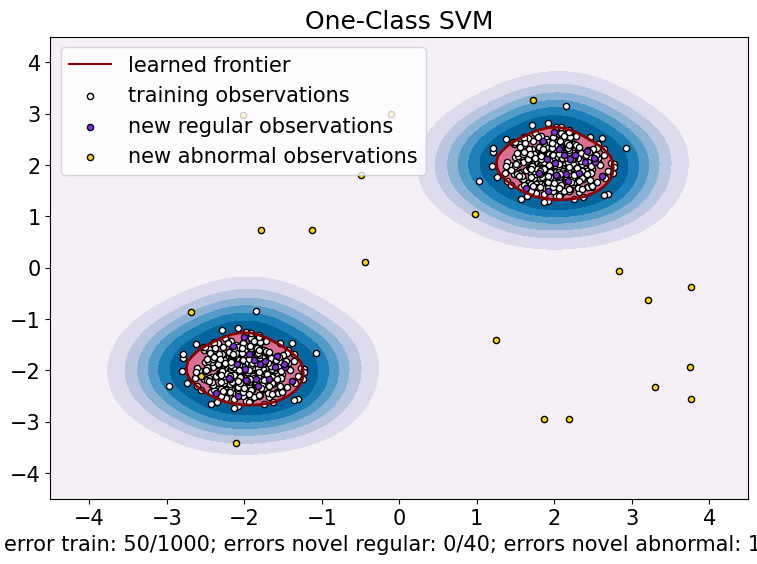

In [6]:
from sklearn.inspection import DecisionBoundaryDisplay

_, ax = plt.subplots(figsize=(9, 6))

xx, yy = np.meshgrid(np.linspace(-4.5, 4.5, 50), np.linspace(-4.5, 4.5, 50))
X = np.concatenate([xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)], axis=1)
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="decision_function",
    plot_method="contourf",
    ax=ax,
    cmap="PuBu",
)
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="decision_function",
    plot_method="contour",
    ax=ax,
    linewidths=2,
    colors="darkred",
    levels=[0],
)
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="decision_function",
    plot_method="contourf",
    ax=ax,
    colors="palevioletred",
    levels=[0, clf.decision_function(X).max()],
)

s = 20
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=s, edgecolors="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="blueviolet", s=s, edgecolors="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="gold", s=s, edgecolors="k")

ax.set(
    title="One-Class SVM",
    xlim=(-4.5, 4.5),
    ylim=(-4.5, 4.5),
    xlabel=(
        f"error train: {n_error_train}/{X_train.shape[0]}; "
        f"errors novel regular: {n_error_test}/{X_test.shape[0]}; "
        f"errors novel abnormal: {n_error_outliers}/{X_outliers.shape[0]}"
    ),
)
_ = ax.legend(
    [mlines.Line2D([], [], color="darkred", label="learned frontier"), b1, b2, c],
    [
        "learned frontier",
        "training observations",
        "new regular observations",
        "new abnormal observations",
    ],
    loc="upper left",
)

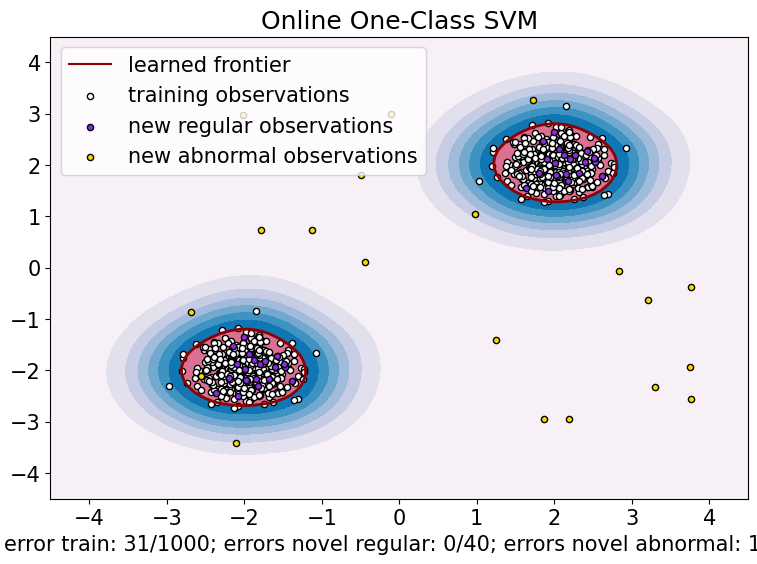

In [7]:
_, ax = plt.subplots(figsize=(9, 6))

xx, yy = np.meshgrid(np.linspace(-4.5, 4.5, 50), np.linspace(-4.5, 4.5, 50))
X = np.concatenate([xx.ravel().reshape(-1, 1), yy.ravel().reshape(-1, 1)], axis=1)
DecisionBoundaryDisplay.from_estimator(
    pipe_sgd,
    X,
    response_method="decision_function",
    plot_method="contourf",
    ax=ax,
    cmap="PuBu",
)
DecisionBoundaryDisplay.from_estimator(
    pipe_sgd,
    X,
    response_method="decision_function",
    plot_method="contour",
    ax=ax,
    linewidths=2,
    colors="darkred",
    levels=[0],
)
DecisionBoundaryDisplay.from_estimator(
    pipe_sgd,
    X,
    response_method="decision_function",
    plot_method="contourf",
    ax=ax,
    colors="palevioletred",
    levels=[0, pipe_sgd.decision_function(X).max()],
)

s = 20
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=s, edgecolors="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="blueviolet", s=s, edgecolors="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="gold", s=s, edgecolors="k")

ax.set(
    title="Online One-Class SVM",
    xlim=(-4.5, 4.5),
    ylim=(-4.5, 4.5),
    xlabel=(
        f"error train: {n_error_train_sgd}/{X_train.shape[0]}; "
        f"errors novel regular: {n_error_test_sgd}/{X_test.shape[0]}; "
        f"errors novel abnormal: {n_error_outliers_sgd}/{X_outliers.shape[0]}"
    ),
)
ax.legend(
    [mlines.Line2D([], [], color="darkred", label="learned frontier"), b1, b2, c],
    [
        "learned frontier",
        "training observations",
        "new regular observations",
        "new abnormal observations",
    ],
    loc="upper left",
)
plt.show()